# National Science Foundation (NSF) Research Awards Abstracts

Author: Francisco Genaro Cerna Fukuzaki

The dataset used in this Jupyter Notebook was downloaded from https://www.nsf.gov/awardsearch/download?DownloadFileName=2020&All=true. Its contains a ZIP file with more than 13,121 XML files.

The goal of this Notebook is to group abstracts of the NSF based on their semantic similarity developing an unsupervised model which classifies abstracts into a topic. The list of topics is not defined yet, it will be after training the model.

## **List of contents:**

1. [Download the dataset](#download-dataset)
2. [Extract the content of the raw dataset](#extract-content)
3. [Exploratory Data Analysis](#exploratory-data-analysis)
4. [Text Preprocessing](#text-preprocessing)
    1. [Natural Language Toolkit (NLTK)](#nltk)
    2. [Stanza](#stanza)
    3. [Transformers](#transformers)
5. [Word Embedding](#word-embedding)
6. [Unsupervised clustering](#unsupervised-clustering)
    1. [K-Means](#k-means)
    2. [Hieralchical Clustering with Transformers](#hieralchical-clustering-transfomers)
7. [Saving the model](#save-model)
8. [Conclusions and Future works](#future-works)
9. [References](#references)

<a name="download-dataset"></a>
## Download the dataset

The dataset contains a ZIP file with more than 13,121 XML files about National Science Foundation (NSF) Research Awards Abstracts. The ZIP file was downloaded from https://www.nsf.gov/awardsearch/download?DownloadFileName=2020&All=true.

After download the ZIP file, the XML files will be unzipped and located in a directory named `temp`.

In [1]:
import requests
import zipfile
import os

In [2]:
url = 'https://www.nsf.gov/awardsearch/download?DownloadFileName=2020&All=true'
filename = 'file.zip'

response = requests.get(url)

with open(filename, "wb") as out_file:
    out_file.write(response.content)
    print(f'File {filename} created.')

File file.zip created.


In [3]:
directory_files_extracted = './temp/'

try:
    file_zip = zipfile.ZipFile(filename, "r")
    os.makedirs(directory_files_extracted, exist_ok=True)
    
    file_zip.extractall(path=directory_files_extracted)
    print('Uncompress succeed.')
except Exception as e:
    print(f'Uncompress with error: {e}')
finally:
    file_zip.close()

Uncompress succeed.


<a name="extract-content"></a>
## Extract the content of the raw dataset

Now I extract the features that I will use for the model. To do this is necessary to check what kind of fields are in each XML file and creating a DataFrame with each value by each XML tag found on the XML file.

In [4]:
from bs4 import BeautifulSoup

In [5]:
list_of_files = [directory_files_extracted + filename for filename in os.listdir(directory_files_extracted)]

In [6]:
try:
    for file_xml in list_of_files:
        with open(file_xml, 'r') as f:
            data = BeautifulSoup(f.read(), 'xml')
            list_columns = [tag.name for tag in data.find_all()]
            print(f"File {file_xml} has {len(set(list_columns))} values.")
except Exception as e:
    print(f'Error: {e}')

Se truncaron las últimas líneas 5000 del resultado de transmisión.
File ./temp/2032136.xml has 67 values.
File ./temp/2049631.xml has 67 values.
File ./temp/2026135.xml has 67 values.
File ./temp/2051559.xml has 67 values.
File ./temp/2038704.xml has 67 values.
File ./temp/2021768.xml has 66 values.
File ./temp/2052614.xml has 67 values.
File ./temp/2021305.xml has 67 values.
File ./temp/2006645.xml has 67 values.
File ./temp/2031535.xml has 67 values.
File ./temp/2011503.xml has 66 values.
File ./temp/2009095.xml has 67 values.
File ./temp/2007284.xml has 68 values.
File ./temp/2006278.xml has 68 values.
File ./temp/2027758.xml has 67 values.
File ./temp/2029557.xml has 67 values.
File ./temp/2016035.xml has 67 values.
File ./temp/2003337.xml has 67 values.
File ./temp/2035583.xml has 70 values.
File ./temp/2032119.xml has 68 values.
File ./temp/2015190.xml has 67 values.
File ./temp/2025974.xml has 70 values.
File ./temp/2037815.xml has 66 values.
File ./temp/2029603.xml has 70 value

There are some XML files with more fields or tags than the others XML files. For that reason, I create a dictionary to be carefull about specifics tag's names are in common for the DataFrame.

In [7]:
import pandas as pd

In [8]:
try:
    list_researches = []
    for file_xml in list_of_files:
        with open(file_xml, 'r') as f:
            data = BeautifulSoup(f.read(), 'xml')
            tuple_fields = ((tag.name, tag.text) for tag in data.find_all())
            research_item = dict((field, value) for field, value in tuple_fields)
            list_researches.append(research_item)
    df = pd.DataFrame(list_researches)
except Exception as e:
    print(f'Error: {e}')

<a name="exploratory-data-analysis"></a>
### Exploratory Data Analysis
 

Following I check the type of data in the DataFrame.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13132 entries, 0 to 13131
Data columns (total 71 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   rootTag                  13132 non-null  object
 1   Award                    13132 non-null  object
 2   AwardTitle               13132 non-null  object
 3   AGENCY                   12736 non-null  object
 4   AwardEffectiveDate       13132 non-null  object
 5   AwardExpirationDate      13132 non-null  object
 6   AwardTotalIntnAmount     13132 non-null  object
 7   AwardAmount              13132 non-null  object
 8   AwardInstrument          13132 non-null  object
 9   Value                    13132 non-null  object
 10  Organization             13132 non-null  object
 11  Code                     13132 non-null  object
 12  Directorate              13132 non-null  object
 13  Abbreviation             13132 non-null  object
 14  LongName                 13132 non-nul

After checking all fields, there are only object type and some of them don't have values. For that reason, the best option is eliminate all fields with less fields that needs the model. To assurance what fields I don't need I will check what values are in the DataFrame.

In [10]:
df.head()

,rootTag,Award,AwardTitle,AGENCY,AwardEffectiveDate,AwardExpirationDate,AwardTotalIntnAmount,AwardAmount,AwardInstrument,Value,Organization,Code,Directorate,Abbreviation,LongName,Division,ProgramOfficer,SignBlockName,PO_EMAI,PO_PHON,AbstractNarration,MinAmdLetterDate,MaxAmdLetterDate,ARRAAmount,TRAN_TYPE,CFDA_NUM,NSF_PAR_USE_FLAG,FUND_AGCY_CODE,AWDG_AGCY_CODE,AwardID,Investigator,FirstName,LastName,PI_MID_INIT,PI_SUFX_NAME,PI_FULL_NAME,EmailAddress,PI_PHON,NSF_ID,StartDate,EndDate,RoleCode,Institution,Name,CityName,ZipCode,PhoneNumber,StreetAddress,StreetAddress2,CountryName,StateName,StateCode,CONGRESSDISTRICT,CONGRESS_DISTRICT_ORG,ORG_DUNS_NUM,ORG_LGL_BUS_NAME,ORG_PRNT_DUNS_NUM,Performance_Institution,CountryCode,CountryFlag,CONGRESS_DISTRICT_PERF,ProgramElement,Text,ProgramReference,Appropriation,APP_SYMB_ID,FUND_OBLG,CountyName,POR,DRECONTENT,POR_COPY_TXT
0,\n\nModifying the floral microenvironment: ele...,\nModifying the floral microenvironment: eleva...,Modifying the floral microenvironment: elevati...,NSF,09/15/2020,08/31/2023,455869.00,455869,\nStandard Grant\n,Standard Grant,\n08090300\n\nBIO\nDirect For Biological Scien...,0120,\nBIO\nDirect For Biological Sciences\n,IOS,Division Of Integrative Organismal Systems,\nIOS\nDivision Of Integrative Organismal Syst...,\nIrwin Forseth\niforseth@nsf.gov\n7032927862\n,Irwin Forseth,iforseth@nsf.gov,7032927862,Highly mobile animals can relocate to microhab...,04/23/2020,04/23/2020,,Grant,47.074,1,4900,4900,2015459,\nMatthew\nKoski\n\n\nMatthew Koski\nmkoski@cl...,Matthew,Koski,,,Matthew Koski,mkoski@clemson.edu,8646563163,000632021,04/23/2020,,Principal Investigator,\nClemson University\nCLEMSON\n296345701\n8646...,NSF RESEARCH & RELATED ACTIVIT,Clemson,296340001,8646562424,230 Kappa Street,Suite 200,United States,South Carolina,SC,03,SC03,042629816,CLEMSON UNIVERSITY,042629816,\nClemson University\nClemson\nSC\n296340001\n...,US,1,SC03,\n7657\nIntegrtv Ecological Physiology\n,GRADUATE INVOLVEMENT,\n9179\nGRADUATE INVOLVEMENT\n,\n0120\nNSF RESEARCH & RELATED ACTIVIT\n040100\n,040100,2020~455869,NaN,NaN,NaN,NaN
1,\n\nCollaborative Research: Expanding and Eval...,\nCollaborative Research: Expanding and Evalua...,Collaborative Research: Expanding and Evaluati...,NSF,08/01/2020,07/31/2023,66486.00,66486,\nStandard Grant\n,Standard Grant,\n11040000\n\nEHR\nDirect For Education and Hu...,0420,\nEHR\nDirect For Education and Human Resources\n,DUE,Division Of Undergraduate Education,\nDUE\nDivision Of Undergraduate Education\n,\nPushpa Ramakrishna\npusramak@nsf.gov\n703292...,Pushpa Ramakrishna,pusramak@nsf.gov,7032922943,This project aims to serve the national intere...,07/28/2020,07/28/2020,,Grant,47.076,1,4900,4900,2013281,\nJohanna\nVarner\n\n\nJohanna Varner\njvarner...,Johanna,Varner,,,Johanna Varner,jvarner@coloradomesa.edu,9702481180,000792689,07/28/2020,,Principal Investigator,\nColorado Mesa University\nGrand Junction\n81...,NSF Education & Human Resource,Grand Junction,815013122,9702481424,1100 North Avenue,,United States,Colorado,CO,03,CO03,075759837,COLORADO MESA UNIVERSITY,075759837,\nColorado Mesa University\nGrand Junction\nCO...,US,1,CO03,\n1998\nIUSE\n,UNDERGRADUATE EDUCATION,\n9178\nUNDERGRADUATE EDUCATION\n,\n0420\nNSF Education & Human Resource\n040106\n,040106,2020~66486,NaN,NaN,NaN,NaN
2,\n\nCollaborative Research: A Deeply Integrate...,\nCollaborative Research: A Deeply Integrated ...,Collaborative Research: A Deeply Integrated Ph...,NSF,09/01/2020,08/31/2023,249638.00,249638,\nStandard Grant\n,Standard Grant,\n07030000\n\nENG\nDirectorate For Engineering...,0120,\nENG\nDirectorate For Engineering\n,CMMI,"Div Of Civil, Mechanical, & Manufact Inn","\nCMMI\nDiv Of Civil, Mechanical, & Manufact I...",\nYueyue Fan\nyfan@nsf.gov\n7032924453\n,Yueyue Fan,yfan@nsf.gov,7032924453,"This grant will develop a novel, deeply integr...",07/07/2020,07/07/2020,,Grant,47.041,1,4900,4900,2000156,\nAbdollah\nShafieezadeh\n\n\nAbdollah Shafiee...,Abdollah,Shafieezadeh,,,Abdollah S

Looking into the data of the dataset there are columns and fields repetitive such as `rootTag`,	`Award` and	`AwardTitle`, another case is `AwardInstrument`	and `Value`. The reason for this problem is that the tag child has more than one tag parent.

Fortunately, the main fields that I consider features for the model don't have this problem specifically **AbstractNarration**. This field has some white space value, so I only considered rows with no white space.

In [12]:
df[df['AbstractNarration'].str.len() == 0]['AbstractNarration']

20        
67        
188       
965       
1421      
        ..
12298     
12905     
12942     
13052     
13068     
Name: AbstractNarration, Length: 70, dtype: object

In [14]:
df = df[df['AbstractNarration'].str.len() > 0]

In [15]:
print(f"There are {df['AbstractNarration'].size} abstracts.")

There are 13062 abstracts.


<a name="text-preprocessing"></a>
## Text Preprocessing

An advantage of this dataset is that every **AbstractNarration** field is in English. For that reason it is not necessary to use a Natural Language Processing (NLP) library with support with another languages.

To have a clean dataset I will preprocess the raw dataset considering the following tasks:

1. Remove punctuations.
2. Remove stopwords.
3. Lemmatization.
4. Delete whitespaces after tokenization.

<a name="nltk"></a>
### Natural Language Toolkit (NLTK)

This Python library has support for English language such as stopwords, punctuations and lemmatization.

To be sure about if this library is enough to the model I will try with a single abstract from the before DataFrame.

In [16]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [19]:
list_texts = df['AbstractNarration'].tolist()

In [20]:
text = list_texts[0]

In [21]:
try:
    word_tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    stop_words.update(string.punctuation)
    
    clean_text = [word.replace('<br>', '').replace('</br>', ' ').replace('br/', '') for word in word_tokens]
    clean_text = [word for word in clean_text if len(word) > 0]
    stemmer = WordNetLemmatizer()
    clean_text = [stemmer.lemmatize(word) for word in clean_text]
    clean_text = [word.lower() for word in clean_text if not word.lower() in stop_words]
    
    print(clean_text)
except Exception as e:
    print(f'Error: {e}')

285
['highly', 'mobile', 'animal', 'relocate', 'microhabitats', 'suit', 'thermal', 'requirement', 'ambient', 'temperature', 'either', 'extremely', 'hot', 'cold', 'called', 'thermoregulation', 'plants', 'however', 'subject', 'ambient', 'temperature', 'condition', 'detrimental', 'reproductive', 'success', 'investigation', 'test', 'whether', 'high', 'elevation', 'population', 'wild', 'perennial', 'plant', 'southern', 'colorado', 'rockies', 'locally', 'adapted', 'cool', 'temperature', 'mechanism', 'increase', 'flower', 'temperature', 'whereas', 'low', 'elevation', 'population', 'adaptive', 'mechanism', 'lower', 'flower', 'temperature', 'high', 'ambient', 'temperature', 'work', 'pinpoint', 'mechanism', 'flower', 'warm', 'cool', 'internal', 'floral', 'temperature', 'test', 'variation', 'thermoregulatory', 'ability', 'impact', 'plant', 'reproductive', 'fitness', 'plant-pollinator', 'interaction', 'award', 'involve', 'undergraduate', 'clemson', 'university', 'research', 'stem', 'field', 'study

A problem with this library is that it does not consider some words with contractions in English language. For that reason I try with another Python library.

<a name="stanza"></a>
### Stanza

This Python library was developed by Standford University. One advantage of this is Pipeline where you can set a specific NLP task for preprocessing like tokenization, part-of-speech tagging or lemmatization.

Again, to be sure about if this library is enough to the model I will try with a single abstract from the before DataFrame.

In [22]:
!pip install stanza

     |████████████████████████████████| 342 kB 14.6 MB/s 


In [23]:
import stanza
stanza.download('en')

2021-09-10 16:56:33 INFO: Downloading default packages for language: en (English)...


2021-09-10 16:57:56 INFO: Finished downloading models and saved to /root/stanza_resources.


Some attibutes of the sentences after processing by Pipeline are:

- `word.lemma`: Gets the lemma of the word.

- `word.upos`: Gets the Universal POS Tagging such as Punctuation, Symbols or unrecognized words.

- `word.xpos`: Gets the Parts Of Speech.

In [24]:
nlp = stanza.Pipeline('en', processors='tokenize,lemma,pos', verbose=False, use_gpu=True)
black_list_tag = ['PART','AUX','SCONJ','DET','ADP','CCONJ','PUNCT','SYM','X']
black_list_words = ['br/><']
list_stopwords = stopwords.words('english')

def text_processing(text):
    doc = nlp(text)    
    #list_words_per_abstract = [(word.lemma,word.upos,word.xpos) for sent in doc.sentences for word in sent.words if word.upos not in black_list_tag]
    #list_words_per_abstract = [word for word in list_words_per_abstract if word[0] not in black_list_words or word[0] not in list_stopwords]
    list_words_per_abstract = [word.lemma for sent in doc.sentences for word in sent.words if word.upos not in black_list_tag]
    list_words_per_abstract = [word for word in list_words_per_abstract if word not in black_list_words or word not in list_stopwords]
    return list_words_per_abstract

text_processing(text)

#### Preprocessing with Stanza

After looking into the results for the first abstract of the dataset I decided that the best option is Stanza Library.

But it take a lot of time (more than 2 hours) to process all the abstracts (more than 13 thousand) using CPU or GPU, for both are the same time. That means that is neccesarry change configuration in Stanza Library to use in GPU.

In [25]:
words_preprocessed = []
for i,text in enumerate(list_texts):
    words_preprocessed.append(text_processing(text))
    if i % 100 == 0:
        print(f'{i} lines was preprocessed.')
words_preprocessed

To don't waste time preprocessing again I save the result in a CSV field.

In [26]:
import csv
import ast

In [27]:
file_name = 'words_preprocessed.csv'

"""
with open(file_name, 'w') as f:
    wr = csv.writer(f)
    wr.writerows(words_preprocessed)


## If read a saved file as a list of tuple with lemma and POS Tagging
words_preprocessed = []
with open(file_name, 'r') as f:
    csv_reader = csv.reader(f)
    for row in csv_reader:
        words_preprocessed_aux = [ast.literal_eval(tupla)[0] for tupla in row]
        words_preprocessed.append(words_preprocessed_aux)
"""

In [28]:
file_name = 'words_preprocessed_lemma.csv'
"""
with open(file_name, 'w') as f:
    wr = csv.writer(f)
    wr.writerows(words_preprocessed)
"""
words_preprocessed = []
with open(file_name, 'r') as f:
    csv_reader = csv.reader(f)
    for row in csv_reader:
        words_preprocessed_aux = [word for word in row]
        words_preprocessed.append(words_preprocessed_aux)

Finally, I create a list with all the abstract preprocessed.

In [29]:
list_texts_clean = []
for words in words_preprocessed:
    list_texts_clean.append(' '.join(words))

In [30]:
list_texts_clean[0]

'project aim use Isaac Newton large manuscript Nachlass collection unpublished manuscript leave death platform explore assess combine use multiple technique date manuscript project focus alchemical writings include laboratory notebook index alchemical substance transcription source research team develop integrative approach assess datum generate use technique manuscript project use network graph analysis determine relative chronology part large body manuscript solution chronology Newton alchemical manuscript serve promote good understanding place field particular period involvement research extend four decade involve numerous contact collaborator important right solution problem date large manuscript collection benefit researcher many area scholarship addition history science mention librarian museum worker research team develop method integrate datum generate use multiple technique generate chronology Newton Nachlass technique include computational method text analysis e.g. latent Sem

<a name="transformers"></a>
### Transformers

This architecture has as an advantage that is not necessary to lemmatize a sentences to be preprocessed because it uses pretrained language models for specifics languages.

A disadvantage of this library is you have to use GPU to get a better performance than use CPU because it use a lot of computational resources when your dataset is big. For that reason I only take some abstracts of the total of the DataFrame preprocessed before.

To identify the similarity of the sentences I will check the cosine score of comparing two sentences based on Euclidean Distance. The cosine score output 0 if the sentences don't have similarity and 1 if both are similar. That will help me to cluster the sentences with a short distance.

In [32]:
!pip install transformers

In [33]:
!pip install sentence-transformers

In [34]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

In [35]:
model = SentenceTransformer('stsb-roberta-large')

In [36]:
corpus = list_texts_clean[:500]
sentences_list = []

for i,sentence_1 in enumerate(corpus):
    embedding1 = model.encode(sentence_1, convert_to_tensor=True)
    for idx,sentence_2 in enumerate(corpus[i+1:]):
        if idx % 100 == 0:
            print(f'Loading sentences with index: {i}-{idx}.')
        embedding2 = model.encode(sentence_2, convert_to_tensor=True)
        cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
        # if cosine is equal to 1, there are no differences
        sentences_list.append([corpus.index(sentence_1),
                               corpus.index(sentence_2),
                               0 if 1-cosine_scores.item() < 0 else 1-cosine_scores.item()])

In [37]:
sentences_df = pd.DataFrame(sentences_list, columns=['Sentence_1','Sentence_2','Score'])

In [38]:
sentences_df.head()

,Sentence_1,Sentence_2,Score
0,0,1,0.643737
1,0,2,0.501373
2,0,3,0.501797
3,0,4,0.629799
4,0,5,0.628305


The DataFrame comparing two sentences and the Euclidean Distance (score) is saved in a file. It will be used in [Section Hieralchical Clustering Transfomers](#hieralchical-clustering-transfomers).

In [40]:
sentences_df.to_csv('hieralchical-clustering-transfomers.csv')

<a name="word-embedding"></a>
## Word Embedding

To use the cleaned dataset in a model I have to vectorize the sentences of the abstract. In this case I will use Word Embedding with TF-IDF to count how many words (n grams) are in the abstract and how many words are repetead and unique in the abstract. This is helpful to only consider words most commonly in a text.

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
corpus_wordembedding = list_texts_clean[:500]

In [43]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,4), min_df=0)
tf.fit(corpus_wordembedding)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=0, ngram_range=(1, 4), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [45]:
tf_transformed = tf.transform(corpus_wordembedding)

<a name="unsupervised-clustering"></a>
## Unsupervised clustering algorithm K-means

<a name="k-means"></a>
### K-Means

K-Means is an unsupervised Machine Learning algorithm to cluster using numeric data and choosing a number of cluster. To verify what is the best number of cluster you may choose a random number or use the Elbow Method. This method let me see where the curve is decreasing less, that will be the number of clusters to use.

In [46]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [47]:
wcss = [] #suma de los cuadrados
for i in range(2, 25):
    print(f'Testing with {i} clusters.')
    kmeans = KMeans(n_clusters=i, max_iter=300)
    kmeans.fit(tf_transformed)
    wcss.append(kmeans.inertia_)

Testing with 2 clusters.
Testing with 3 clusters.
Testing with 4 clusters.
Testing with 5 clusters.
Testing with 6 clusters.
Testing with 7 clusters.
Testing with 8 clusters.
Testing with 9 clusters.
Testing with 10 clusters.
Testing with 11 clusters.
Testing with 12 clusters.
Testing with 13 clusters.
Testing with 14 clusters.
Testing with 15 clusters.
Testing with 16 clusters.
Testing with 17 clusters.
Testing with 18 clusters.
Testing with 19 clusters.
Testing with 20 clusters.
Testing with 21 clusters.
Testing with 22 clusters.
Testing with 23 clusters.
Testing with 24 clusters.


The next lines show a graphic of the Elbow Method using differents numbers of clusters. It show how is posible to increase the number of clusters to get finally a best number.

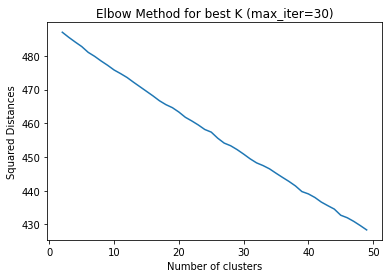

In [48]:
plt.plot(range(2,50), wcss)
plt.title("Elbow Method for best K (max_iter=30)")
plt.xlabel("Number of clusters")
plt.ylabel("Squared Distances")
plt.show()

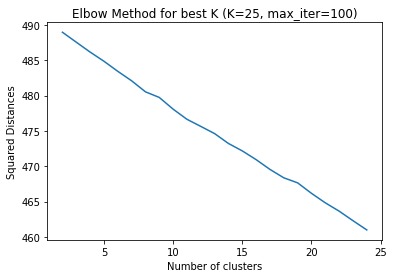

In [49]:
plt.plot(range(2,25), wcss)
plt.title("Elbow Method for best K (K=25, max_iter=100)")
plt.xlabel("Number of clusters")
plt.ylabel("Squared Distances")
plt.show()

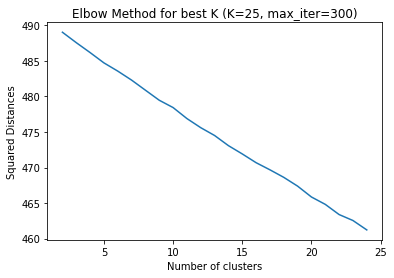

In [50]:
plt.plot(range(2,25), wcss)
plt.title("Elbow Method for best K (K=25, max_iter=300)")
plt.xlabel("Number of clusters")
plt.ylabel("Squared Distances")
plt.show()

Looking into the graphs, the number of cluster chooosen to be the best for the model is 23.

In [51]:
best_number = 23

lines_for_predicting = ["The present paper is about technology and how cure the cancer."]
model_kmeans = KMeans(n_clusters=best_number, max_iter=300)
model_kmeans.fit(tf_transformed)
model_kmeans.predict(tf.transform(lines_for_predicting))

array([18], dtype=int32)

<a name="hieralchical-clustering-transfomers"></a>
### Hieralchical Clustering with Ttransfomers

Cotinuing the section before about Transformers. I load the CSV file to train the model.

The first is a K-Means model with 5 clusters to check the efficiency of the Euclidean Distance between two sentences.

In [53]:
df_score = pd.read_csv('hieralchical-clustering-transfomers.csv')
df_score.head()

,Unnamed: 0,Sentence_1,Sentence_2,Score
0,0,0,1,0.643737
1,1,0,2,0.501373
2,2,0,3,0.501797
3,3,0,4,0.629799
4,4,0,5,0.628305


In [55]:
from sklearn.cluster import KMeans
x = df_score[['Sentence_1','Sentence_2','Score']]
model = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_clusters = model.fit_predict(x)

In [56]:
df_aux_d = x
df_aux_d['cluster'] = y_clusters
df_aux_d.tail()

,Sentence_1,Sentence_2,Score,cluster
6466,4,56,0.554939,2
6467,4,57,0.709406,2
6468,4,58,0.565549,2
6469,4,59,0.521268,2
6470,4,60,0.618601,2


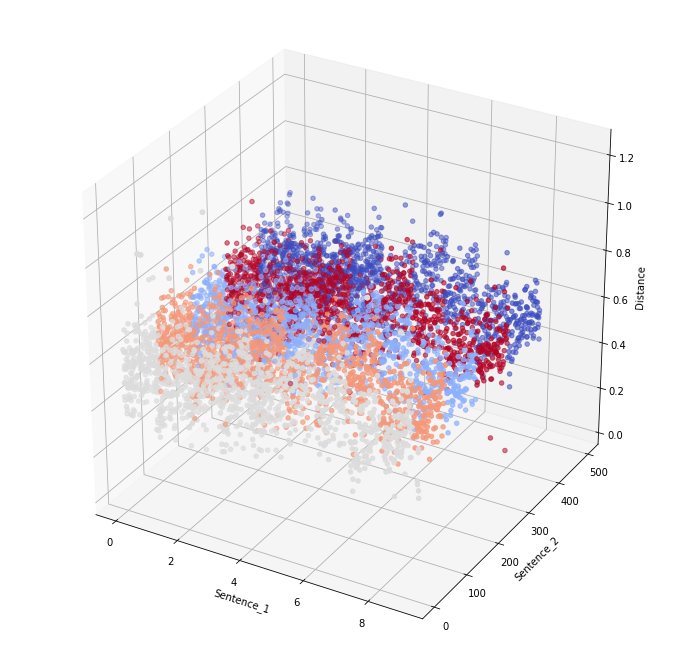

In [58]:
y = df_aux_d.iloc[:,1]
x = df_aux_d.iloc[:,0]
z = df_aux_d.iloc[:,2]
c = df_aux_d['cluster']
fig = plt.figure(figsize=(12,12)).gca(projection='3d')
fig.scatter(x, y, z, c=c, cmap='coolwarm')
fig.set_xlabel('Sentence_1')
fig.set_ylabel('Sentence_2')
fig.set_zlabel('Distance')
plt.show()

Another method is use Dendrogram with the Euclidean distances of each abstract to get a number of clusters based on the distances.

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

X = [[idx,value] for idx,value in enumerate(df_aux_d['Score'].values)]

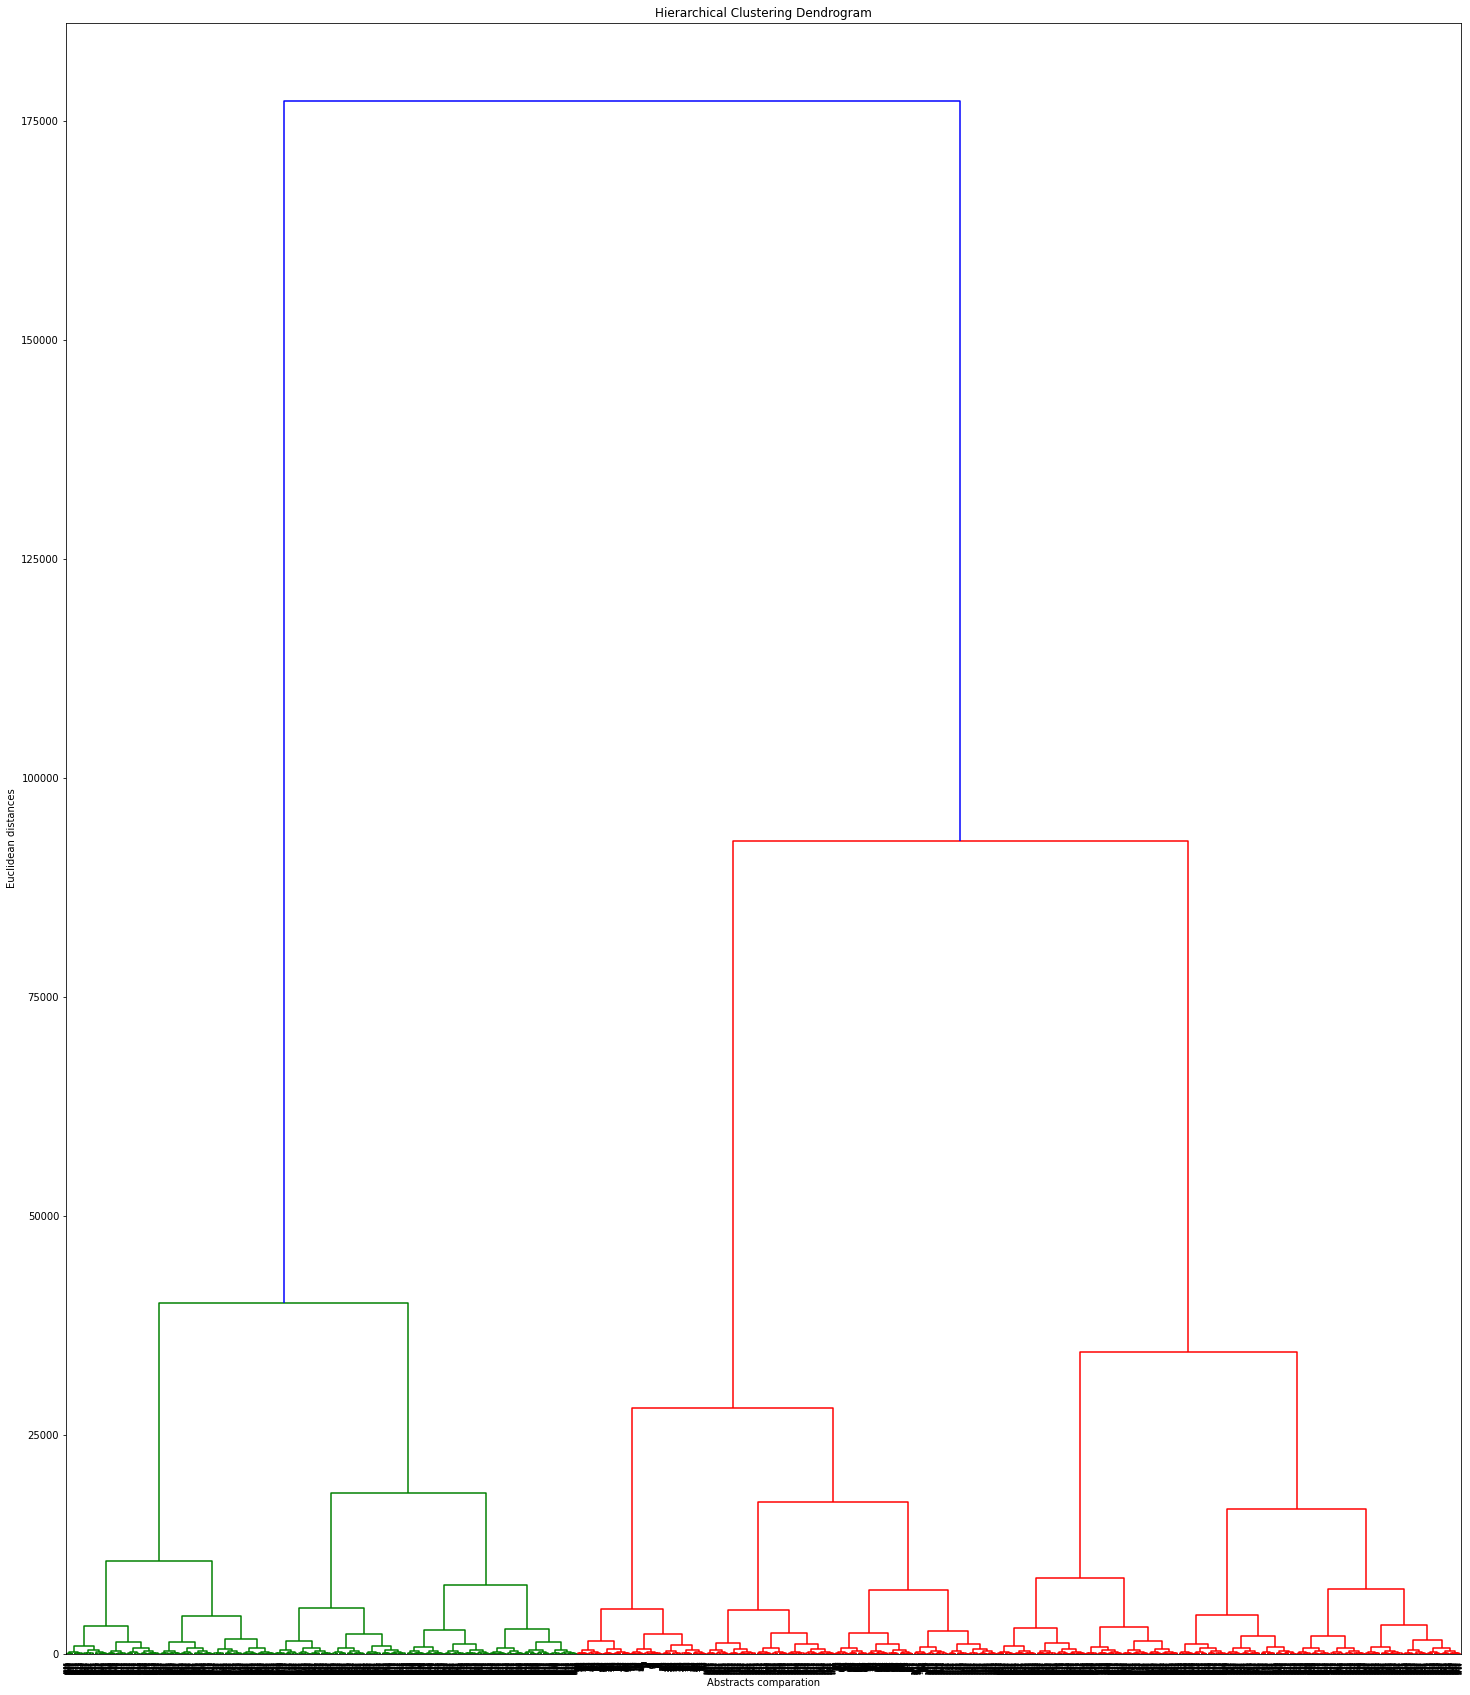

In [60]:
plt.figure(figsize=(25, 30))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Abstracts comparation')
plt.ylabel('Euclidean distances')
sch.dendrogram(sch.linkage(X, method='ward'))
plt.show()

Looking into the dendrogram I think there are 14 clusters using Transformers and Hieralchical Clustering.

<a name="save-model"></a>
## Saving the model

Finally I save the K-Means model to be used in the future.

In [61]:
import pickle

with open("model_kmeans.pkl", "wb") as f:
    pickle.dump(model_kmeans, f)

with open("model_kmeans.pkl", "rb") as f:
    model_kmeans = pickle.load(f)

<a name="future-works"></a>
# Conclusions and Future works

After comparing the results of two unsupervised Machine Learning (ML) algorithms: (1) K-Means and (2) Hieralchical Clustering, and using Python libraries to preprocessing the abstracts, I conclude that the best number of cluster may be get to improve for three reasons:

1. To take advantage of GPU from another cloud services such as AWS SageMaker or Azure Data Science Virtual Machine because they enable to use more GPU and RAM that gave me Google Colab.

2. The time used to preprocessing the model with Transformers. The dataset has more than 13 thousand Abstracts from XML files but I used a little from the dataset. I spent hours waiting for the cleaned text and for the Euclidean Distance between two sentences and get a result to show in this Jupyter Notebook.

3. Use the complete dataset of abstract cleaned. To get a fast result that let me compare both ML algorithm I use less than the 5% of the cleaned dataset.

Some future work to performance the model are:

1. Pandas Library has a method called read_xml that works with 1.3.0 version. However Google Colab doesn't support this version. If you use another Cloud or On-Premise computer, you will try using this command to check and update Pandas Library version `pip install --upgrade pandas --user`.

2. Use more RAM to process all the XML files (more than 13 thousand) because in TDITF the RAM gaven by Google Colab is not enough.

3. Keep testing for more time (hours) with K-Means and more clusters.

4. Keep comparing with all the abstracts from XML files using Transformers and similarities to identify a better number of clusters.


<a name="references"></a>
# References

1. Universal POS tags. Contains the name of each POS tags. https://universaldependencies.org/u/pos/
2. Part of Speech Tags. Contains the abreviations and meanings of the part of speech. https://cs.nyu.edu/~grishman/jet/guide/PennPOS.html